In [1]:
# Forward Euler method to store porovisional Solution
function forwardEU(g, a, b, y0, N)
    
    y=zeros(N+1)
    t=Vector(range(a, b, N+1))
    y[1]=y0
    h=(b-a)/N
    for i in 1:N
        y[i+1] = y[i] .+ h*g(t[i], y[i])
    end
    return t, y
end

forwardEU (generic function with 1 method)

In [2]:
# Lagrange Lagrange Interpolation

using LinearAlgebra, DSP, Polynomials
function Lagrange(t, g, a, b)
    N=length(t)
    p=zeros(1, N)
    L=zeros(N ,N)
    cpoly=zeros(1, N)
    intcpoly=zeros(1, N)
    pval=zeros(N)
    dt=b-a
    s=(t .-a) / dt
    d=0
    for i in 1:N
        p=[1]
        for j in 1:N
            if i !=j
                p = conv(p, [-s[j], 1]) / (s[i] - s[j])
            end
        end
        L[i,:]=p
        cpoly=Polynomial(p)
        intcpoly=integrate(cpoly)
        pval[i]= g[i] * (intcpoly(1) - intcpoly(0))
        d = d .+ pval[i] 
    end
    apprx=dt*d
    return apprx
end

Lagrange (generic function with 1 method)

In [12]:
# Creating RIDC step function

function ridc(g, a, b, h, y0, N, K)
    y=zeros(1, N+1, K+1)
    t, y[1, :, 1]=forwardEU(g, a, b, y0, N) # Storing the provisonal solution
    errfun(t, e, y)= g(t, y .+ e) .- g(t, y)
    e=zeros(N+1)
    e0=0
    e[1]=e0
   for k in 1:K
        y[1, 1, k+1]=y0
        nfval=g(t, y[1, :, k])
        for n in 2:k
            e[n]=e[n-1] .- (y[1, n, k] .- y[1, n-1, k]) + h*errfun(t[n-1], e[n-1], y[1, n-1, k]) + Lagrange(t[1:k+1], nfval[1:k+1], t[n-1], t[n])
            y[1, n, k+1]=y[1, n, k] + e[n]
        end
        for j in (k+1):(N+1)
            e[j]=e[j-1] .- (y[1, j, k] .- y[1, j-1, k]) .+ h*errfun(t[j-1], e[j-1], y[1, j-1, k]) + Lagrange(t[j-k:j], nfval[j-k:j], t[j-1], t[j])
            y[1, j, k+1]=y[1, j, k] .+ e[j]
        end
    end
    return t,  y
end

ridc (generic function with 1 method)

In [3]:
# homegrown polyfit code copied from Dr Ben's RIDC code 

function vander!(V::AbstractMatrix, x::AbstractVector, n=length(x))
    m = length(x)
    (m,n) == size(V) || throw(DimensionMismatch())
    for j = 1:m
        @inbounds V[j,1] = one(x[j])
    end
    for i = 2:n, j = 1:m
        @inbounds V[j,i] = x[j] * V[j,i-1]
    end
    return V
end
vander(x::AbstractVector, n=length(x)) = vander!(Array{eltype(x)}(undef, length(x), n), x, n)

function polyfit!(x::AbstractVector, y::AbstractVector, n)
    return vander(x,n+1)\y
end
polyfit(x::AbstractVector, y::AbstractVector, n) = polyfit!(x, y,n)

polyfit (generic function with 1 method)

# Convergence Study with some Test Problems

convergence order = 0.9915850168049286
convergence order = 1.9826357765141585
convergence order = 2.9684600212322327
convergence order = 3.5946997756088535
convergence order = 4.971726287339074
convergence order = 6.157698308663266


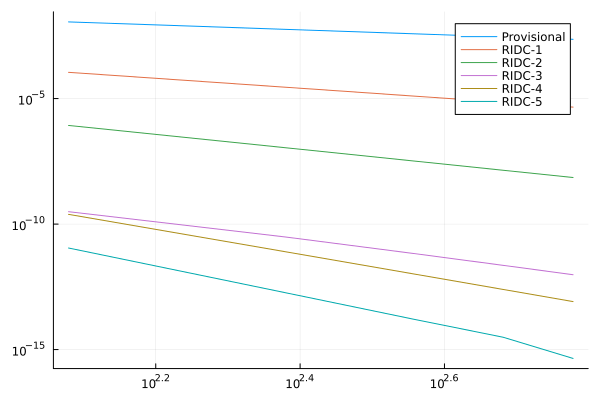

In [16]:
# Test #1 
using Plots
M = 5
N_values = zeros(M)

for i in 1:M
    N_values[i] = 120*(i)
end

K = 5
err = zeros(M, K + 1)

for p in 1:M
    a = 0.0
    b = 0.5
    N = convert(Int, N_values[p])
    h = (b - a) / N
    y0 = 1
    
    g(t, y) = y.^ 2 # Solving for dy/dt = y^2
    (t, y) = ridc(g, a, b, h, y0, N, K)
    
    exact = 1 ./ (1 .- t)
    
    # Storing errors
    for i in 1:K+1
        err[p, i] = norm(exact[N+1] .- y[1, N+1, i])
    end
    
end
# Compute order of convergence and error plot
pdeg = polyfit(log10.(N_values[:]), log10.(err[:, 1]),1)
print("convergence order = ",abs(pdeg[2]),"\n") 
plot(N_values, err[:, 1],xaxis=:log, yaxis=:log, label="Provisional")

for j in 2:K+1
    plot!(N_values, err[:,j],xaxis=:log, yaxis=:log, label="RIDC-$(j-1)")
    pdeg = polyfit(log10.(N_values[:]), log10.(err[:, j]),1)
    print("convergence order = ", abs(pdeg[2]),"\n")
end
display(plot!(legend=:topright))

convergence order = 1.003846412174519
convergence order = 2.009242837131425
convergence order = 2.9839028897757536
convergence order = 3.997952019997798
convergence order = 4.9923240995214515
convergence order = 5.125327314931671
convergence order = 2.588293527420397


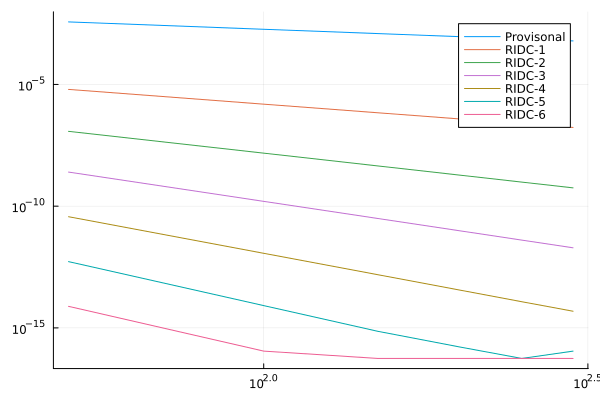

In [10]:
# Test #2
using Plots
M = 6
N_values = zeros(M)

for i in 1:M
    N_values[i] = 50* i
end

K = 6
err1 = zeros(M, K + 1)

for p in 1:M
    a = 0.0
    b = 1
    N = convert(Int, N_values[p])
    h = (b - a) / N
    y0 = 1
    lambda=-1
    #g(t, y) = - y .+ sin.(10*t) # Solving for dy/dt = -y + sin(10t)
    g(t, y)= lambda*y
    (t, y) = ridc(g, a, b, h, y0, N, K)
    
    #exact1 = -(1/101)* exp.(-t) .*(-111 .+10*exp.(t) .*cos.(10*t).- exp.(t) .*sin.(10*t))
    exact1=exp.(lambda*t)
    # Storing errors
    for i in 1:K+1
        err1[p, i] = norm(exact1[N+1] .- y[1, N+1, i])
    end
end

# Compute order of convergence and error plot
pdeg = polyfit(log10.(N_values[:]), log10.(err1[:, 1]),1)
print("convergence order = ",abs(pdeg[2]),"\n") 
plot(N_values, err1[:, 1], xaxis=:log, yaxis=:log, label="Provisonal")

for j in 2:K+1
    plot!(N_values, err1[:,j],xaxis=:log, yaxis=:log, label="RIDC-$(j-1)")
    pdeg = polyfit(log10.(N_values[:]), log10.(err1[:, j]),1)
    print("convergence order = ", abs(pdeg[2]),"\n")
end
display(plot!(legend=:topright))

convergence order = 0.9958950322308161
convergence order = 1.9903964914154673
convergence order = 2.9884455588795307
convergence order = 4.032047417965012
convergence order = 4.972396363603662
convergence order = 6.075984881065157
convergence order = 6.384779689312467


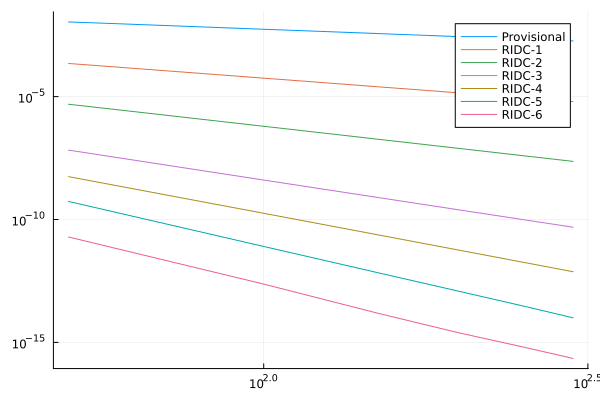

In [14]:
# Test #3
using Plots
M = 6
N_values = zeros(M)

for i in 1:M
    N_values[i] = 50* i
end

K = 6
err2 = zeros(M, K + 1)

for p in 1:M
    a = 0.0
    b = 1
    N = convert(Int, N_values[p])
    h = (b - a) / N
    y0 = 1
    
    g(t, y) = t .* y.^2 .* cos.(t) .^2 # Solving for dy/dt = t* y^2 * cos(t)^2
    (t, y) = ridc(g, a, b, h, y0, N, K)
    
    exact2 = -8 ./(-9 .+ 2* t.^2 .+ cos.(2*t) .+ 2* t .* sin.(2*t))    
    # Storing errors
    for i in 1:K+1
        err2[p, i] = norm(exact2[N+1] .- y[1, N+1, i])
    end
end

# Compute order of convergence and error plot
pdeg = polyfit(log10.(N_values[:]), log10.(err2[:, 1]),1)
print("convergence order = ",abs(pdeg[2]),"\n") 
plot(N_values, err2[:, 1],xaxis=:log, yaxis=:log, label="Provisional")

for j in 2:K+1
    plot!(N_values, err2[:,j],xaxis=:log, yaxis=:log, label="RIDC-$(j-1)")
    pdeg = polyfit(log10.(N_values[:]), log10.(err2[:, j]),1)
    print("convergence order = ", abs(pdeg[2]),"\n")
end
display(plot!(legend=:topright))

# Modified Version of RIDC (An easy discretization of the Error Function)

In [4]:
# Creating RIDC step function
function ridcmod(g, a, b, h, y0, N, K)
    y=zeros(1, N+1, K+1)
    t, y[1, :, 1]=forwardEU(g, a, b, y0, N) # storing the provisional solution
   
   for k in 1:K
        y[1, 1, k+1]=y0
        nfval=g(t, y[1, :, k])
        for n in 2:k
            y[1, n, k+1]=y[1, n-1, k+1] + h* g(t[n-1], y[1, n-1, k+1])- h*g(t[n-1], y[1, n-1, k]) + Lagrange(t[1:k+1], nfval[1:k+1], t[n-1], t[n])
        end
        for j in (k+1):(N+1)
            y[1, j, k+1]=y[1, j-1, k+1] + h*g(t[j-1], y[1, j-1, k+1]) - h*g(t[j-1], y[1, j-1, k]) + Lagrange(t[j-k:j], nfval[j-k:j], t[j-1], t[j])
        end
    end
    return t,  y
end

ridcmod (generic function with 1 method)

convergence order = 0.9915850168049286
convergence order = 1.982635776980576
convergence order = 2.9684596700363173
convergence order = 3.594168402938974
convergence order = 4.989948672640103
convergence order = 5.6842233305423076
convergence order = 3.0448121539525164


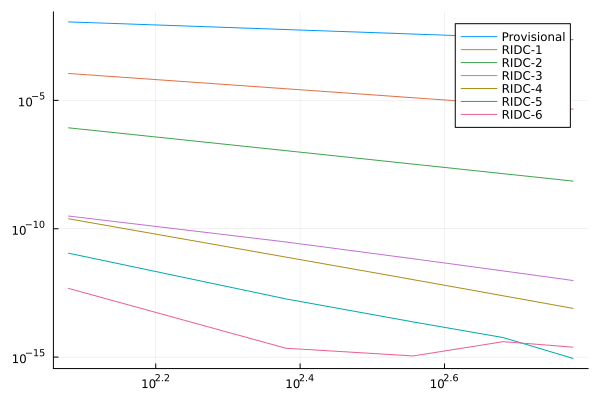

In [5]:
# Convergence Analysis with the Simplified version of RIDC Algorithm
using Plots
M = 5
N_values = zeros(M)

for i in 1:M
    N_values[i] = 120 * i
end

K = 6
err4 = zeros(M, K + 1)

for p in 1:M
    a = 0.0
    b = 0.5
    N = convert(Int, N_values[p])
    h = (b - a) / N
    y0 = 1
    
    g(t, y) = y .^ 2
    (t, y) = ridcmod(g, a, b, h, y0, N, K)
    
    exact4 = 1 ./ (1 .- t)
    
    # Storing errors
    for i in 1:K+1
        err4[p, i] = norm(2 .- y[1, N+1, i])
    end
end

# Compute order of convergence and error plot
pdeg = polyfit(log10.(N_values[:]), log10.(err4[:, 1]),1)
print("convergence order = ",abs(pdeg[2]),"\n") 
plot(N_values, err4[:, 1],xaxis=:log, yaxis=:log, label="Provisional")

for j in 2:K+1
    plot!(N_values, err4[:,j],xaxis=:log, yaxis=:log, label="RIDC-$(j-1)")
    pdeg = polyfit(log10.(N_values[:]), log10.(err4[:, j]),1)
    print("convergence order = ", abs(pdeg[2]),"\n")
end
display(plot!(legend=:topright))

convergence order = 0.9958950322308161
convergence order = 1.9903964911562237
convergence order = 2.988445609121273
convergence order = 4.0320592396637025
convergence order = 4.974463065501323
convergence order = 6.184320831116455
convergence order = 5.163767235736829


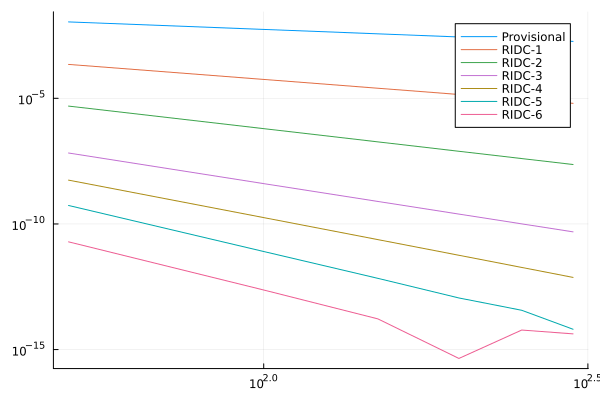

In [13]:
# Test #3
using Plots
M = 6
N_values = zeros(M)

for i in 1:M
    N_values[i] = 50* i
end

K = 6
err2 = zeros(M, K + 1)

for p in 1:M
    a = 0.0
    b = 1
    N = convert(Int, N_values[p])
    h = (b - a) / N
    y0 = 1
    
    g(t, y) = t .* y.^2 .* cos.(t) .^2 # Solving for dy/dt = t* y^2 * cos(t)^2
    (t, y) = ridcmod(g, a, b, h, y0, N, K)
    
    exact2 = -8 ./(-9 .+ 2* t.^2 .+ cos.(2*t) .+ 2* t .* sin.(2*t))    
    # Storing errors
    for i in 1:K+1
        err2[p, i] = norm(exact2[N+1] .- y[1, N+1, i])
    end
end

# Compute order of convergence and error plot
pdeg = polyfit(log10.(N_values[:]), log10.(err2[:, 1]),1)
print("convergence order = ",abs(pdeg[2]),"\n") 
plot(N_values, err2[:, 1],xaxis=:log, yaxis=:log, label="Provisional")

for j in 2:K+1
    plot!(N_values, err2[:,j],xaxis=:log, yaxis=:log, label="RIDC-$(j-1)")
    pdeg = polyfit(log10.(N_values[:]), log10.(err2[:, j]),1)
    print("convergence order = ", abs(pdeg[2]),"\n")
end
display(plot!(legend=:topright))